## Context

- in PAL007, I tried different DE analysis methods and found that psuedobulk with pydeseq produced the best DE lists as well as clustering
- in this notebook, I'm going to try to indentify gene modules using those DE genes
- Ideally, the output would be a violin plot that shows when IFNg is KO, certain modules rise over the NT and TGFbKO, indicating that IFNg signaling is overwriting those modules

## Libraries and Settings

In [108]:
import scanpy as sc
import mudata as md
import pandas as pd
import decoupler as dc
import requests

In [21]:
sc.set_figure_params(dpi=150)
%config InlineBackend.figure_format="retina"

## Import 

In [77]:
mdata = md.read_h5mu("/lustre/fs4/cao_lab/scratch/plaffont/personal_datasets/CTR02/ctr02_processed.h5mu")
rna = mdata["rna"].copy()
del mdata
rna

AnnData object with n_obs × n_vars = 17029 × 32286
    obs: 'spleen-CD62Lpos', 'spleen-CD62Lneg', 'mLN-CD62Lpos', 'mLN-CD62Lneg', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'num_features', 'feature_call', 'num_umis', 'target', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'mixscape_class_p_ko', 'mixscape_class', 'mixscape_class_global'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'mixscape', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'X_pert', 'counts'

- let's clean the object up, low quality cells have already been filtered but there's a lot of junk from mixscape

In [78]:
rna.obs = rna.obs = (
    rna
    .obs
    .loc[:, ["Classification", "mixscape_class"]]
)

rna.var = (
    rna
    .var
    .loc[:, ["gene_ids", "genome", "mt"]]
)

rna.obs["perturbation"] = (
    rna
    .obs
    .mixscape_class
    .replace("Ifngr1 NP", "NP")
    .replace("Tgfbr2 NP", "NP")
    .replace("NT", "NP")
    .cat
    .set_categories(["NP", "Tgfbr2 KO", "Ifngr1 KO"])
)

rna.var["rb"] = rna.var.index.str.startswith(("Rps", "Rpl"))

rna = rna[:, ~rna.var.rb]

del rna.uns["hvg"]
del rna.uns["log1p"]
del rna.uns["pca"]

del rna.obsm["X_pca"]
del rna.varm["PCs"]

rna.X = rna.layers["counts"].copy()

rna

/tmp/ipykernel_12284/3154047679.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("Ifngr1 NP", "NP")
/tmp/ipykernel_12284/3154047679.py:18: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("Tgfbr2 NP", "NP")
/tmp/ipykernel_12284/3154047679.py:19: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  .replace("NT", "NP")
/tmp/ipykernel_12284/31

AnnData object with n_obs × n_vars = 17029 × 32185
    obs: 'Classification', 'mixscape_class', 'perturbation'
    var: 'gene_ids', 'genome', 'mt', 'rb'
    uns: 'hvg', 'log1p', 'mixscape', 'pca'
    layers: 'X_pert', 'counts'

## Preprocessing

### Normalization

In [79]:
sc.pp.normalize_total(rna)
sc.pp.log1p(rna)

In [80]:
pb_de = pd.read_csv("/lustre/fs4/home/plaffont/notebooks_rudenksy/CTR02_CTR03_PL/readouts/psuedobulk_DE.csv", index_col=0)

rna.var = rna.var.join(pb_de)

In [81]:
rna.var["perturbation_Ifngr1 KO_vs_NT"].isna().mean()

0.3420537517477086

- approximately 34% of genes do not have a score, which I think is fine but we can revisit this

In [82]:
q1 = rna.var["perturbation_Ifngr1 KO_vs_NT"].quantile(q = 0.25)
q3 = rna.var["perturbation_Ifngr1 KO_vs_NT"].quantile(q = 0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

tgf_outlier = (rna.var["perturbation_Tgfbr2 KO_vs_NT"] < lower_bound) | (rna.var["perturbation_Tgfbr2 KO_vs_NT"] > upper_bound)
ifn_outlier = (rna.var["perturbation_Ifngr1 KO_vs_NT"] < lower_bound) | (rna.var["perturbation_Ifngr1 KO_vs_NT"] > upper_bound)

rna.var["highly_variable"] = tgf_outlier | ifn_outlier

In [83]:
rna.var.highly_variable.mean()

0.047879446947335716

### Cell Cycle Scoring

In [84]:
def get_cell_cycle_genes() -> list:
    # Canonical list of cell cycle genes
    url = "https://raw.githubusercontent.com/scverse/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt"
    cell_cycle_genes = requests.get(url).text.split("\n")[:-1]
    return cell_cycle_genes

cell_cycle_genes = get_cell_cycle_genes()
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in rna.var_names]

sc.tl.score_genes_cell_cycle(rna, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)

### Precluster

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


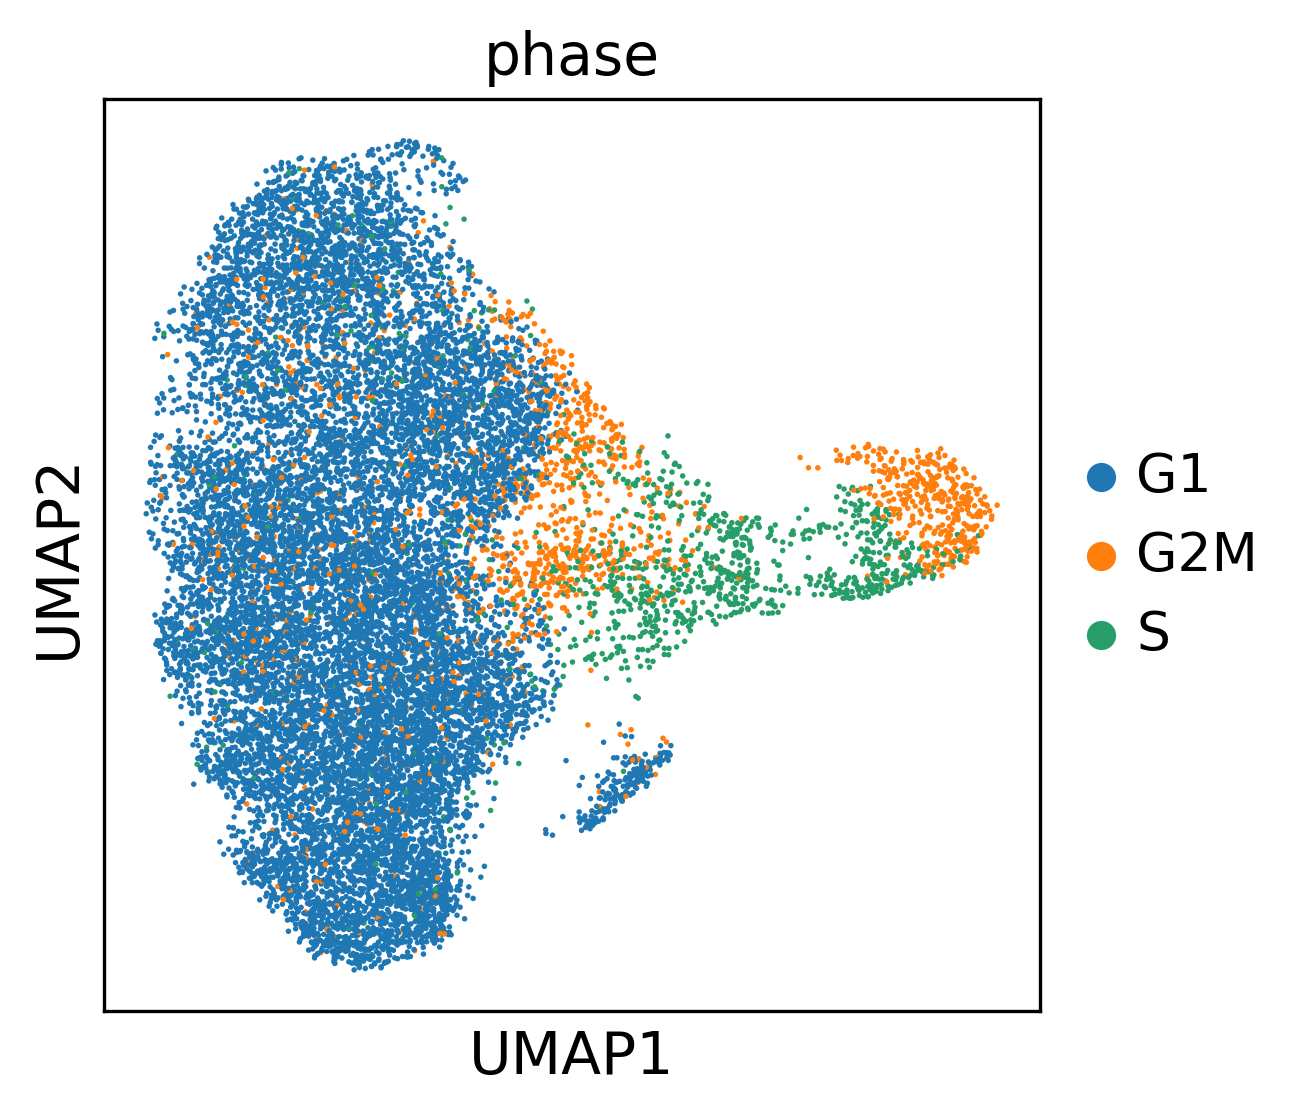

In [85]:
sc.pp.pca(rna, use_highly_variable=True)
sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.pl.umap(rna, color = ["phase"])

- definitely strong cell cycle effects
- scvi model is good at regressing that out, but not necessary at this point

In [103]:
rna = rna[rna.obs.phase == "G1", :]

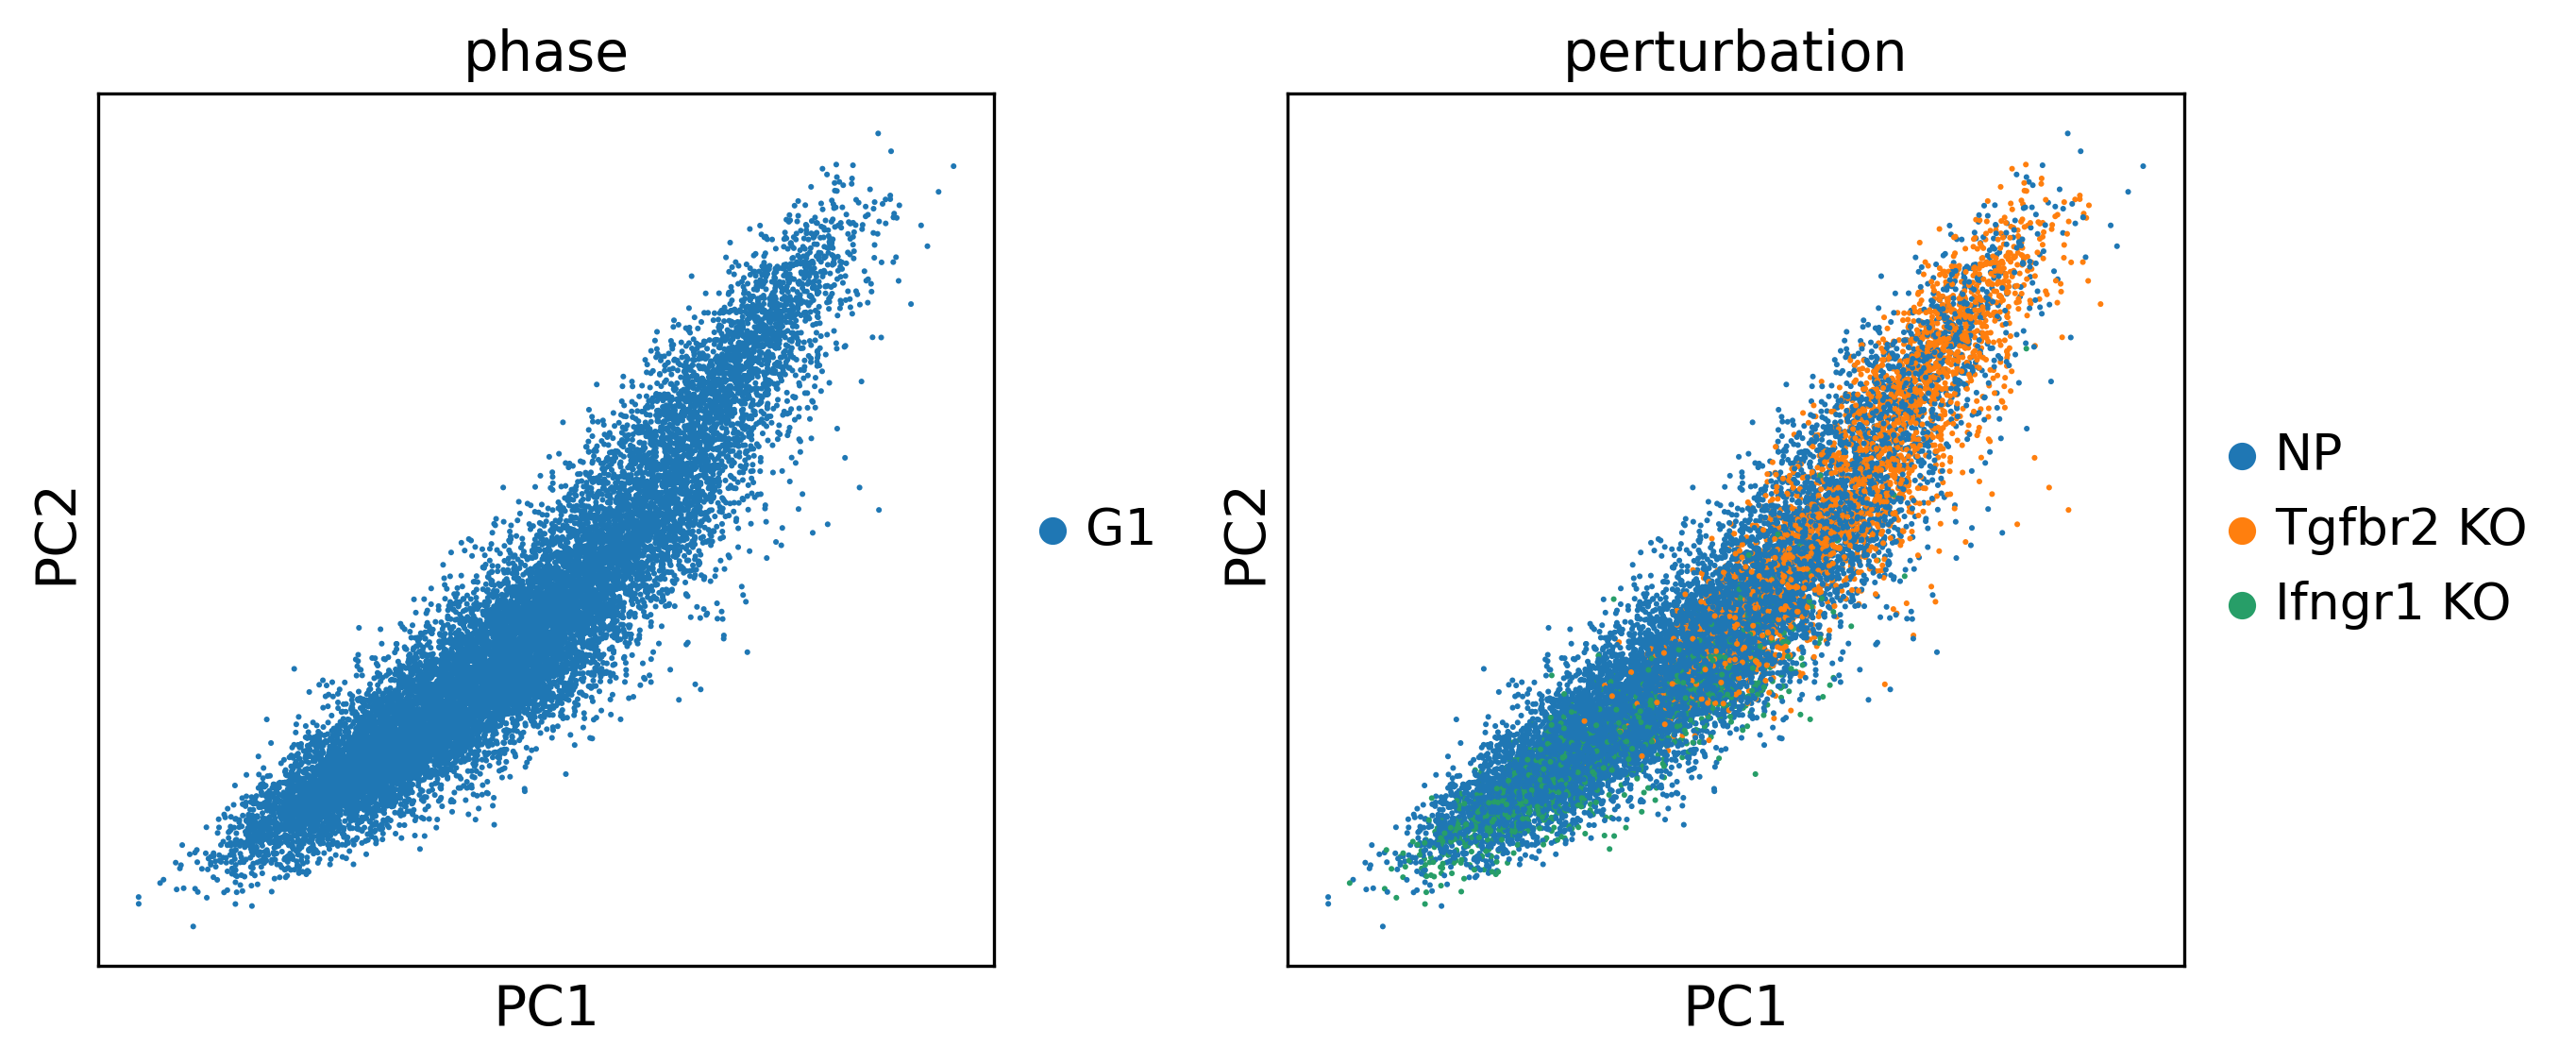

In [104]:
sc.pl.pca(rna, color = ["phase", "perturbation"])

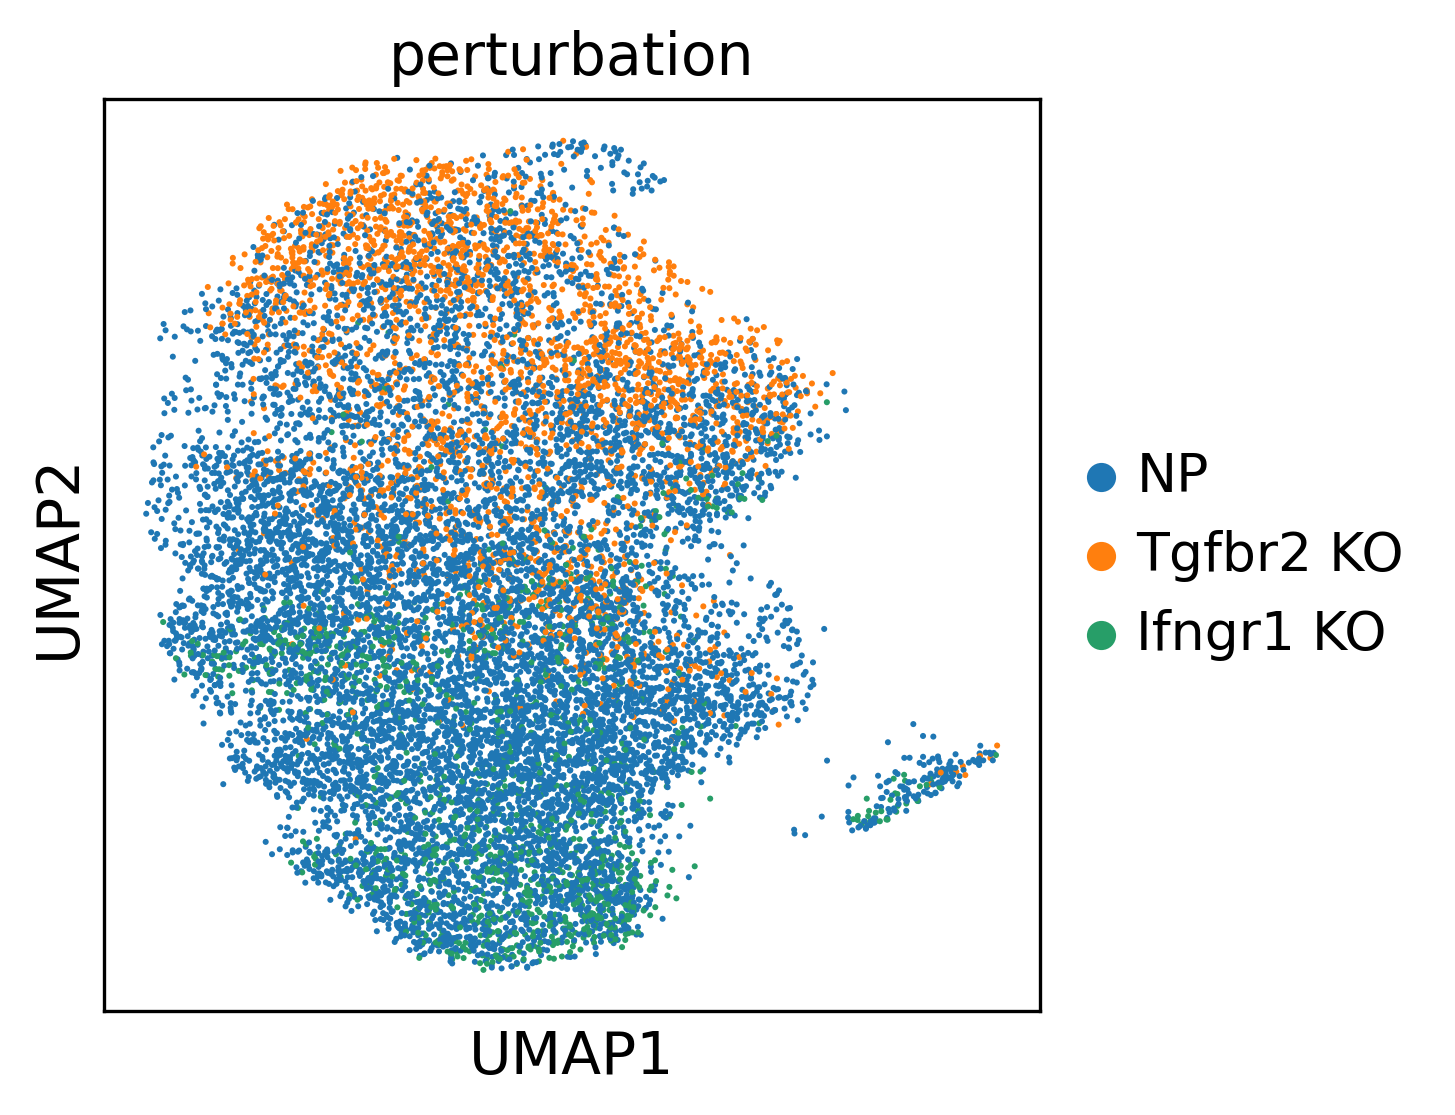

In [106]:
sc.pl.umap(rna, color = "perturbation")

## Gene Module Scoring

In [111]:
msig = dc.get_resource("MSigDB")

In [126]:
immune_genesets.reset_index().drop(columns = "index")

,genesymbol,collection,geneset
0,MAFF,immunesigdb,GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN
1,MAFF,immunesigdb,GSE17721_CTRL_VS_GARDIQUIMOD_6H_BMDC_DN
2,MAFF,immunesigdb,GSE11864_CSF1_PAM3CYS_VS_CSF1_IFNG_PAM3CYS_IN_...
3,MAFF,immunesigdb,GSE9037_CTRL_VS_LPS_1H_STIM_BMDM_DN
4,MAFF,immunesigdb,GSE14415_ACT_VS_CTRL_NATURAL_TREG_UP
...,...,...,...
933972,KIR3DS1,immunesigdb,GSE28408_LY6G_POS_VS_NEG_DC_DN
933973,KIR3DS1,immunesigdb,GSE22886_NAIVE_TCELL_VS_NKCELL_DN
933974,KIR3DS1,immunesigdb,GSE45365_WT_VS_IFNAR_KO_BCELL_MCMV_INFECTION_UP
933975,KIR3DS1,immunesigdb,GSE21927_SPLENIC_C26GM_TUMOROUS_VS_BONE_MARROW...


In [162]:
immune_genesets = msig.query("collection == 'immunesigdb'")
immune_genesets = immune_genesets[~immune_genesets.duplicated(("geneset", "genesymbol"))]
immune_genesets = immune_genesets.reset_index().drop(columns = "index")
immune_genesets = immune_genesets.reset_index().drop(columns = ["index", "collection"])

In [175]:
keep = geneset_size[((geneset_size > 15) & (geneset_size < 500))].index.tolist()

In [190]:
immune_genesets["geneset"] = immune_genesets.geneset.cat.remove_unused_categories()

In [197]:
immune_genesets["genesymbol"] = immune_genesets.genesymbol.str.capitalize()

In [198]:
dc.run_aucell(
    rna,
    immune_genesets,
    source="geneset",
    target="genesymbol",
    use_raw=False
)

/lustre/fs4/cao_lab/store/plaffont/miniforge3/envs/rapids_singlecell/lib/python3.11/site-packages/decoupler/pre.py:286: ImplicitModificationWarning: Setting element `.obsm['aucell_estimate']` of view, initializing view as actual.
  mat.obsm[result.name] = result


In [219]:
df = rna.obsm["aucell_estimate"]
df["perturbation"] = rna.obs["perturbation"]
df = df.melt(id_vars="perturbation", value_vars=df.columns.tolist(), var_name="module", value_name="score")

In [225]:
%load_ext rpy2.ipython

In [230]:
df.to_csv("/lustre/fs4/home/plaffont/notebooks_rudenksy/CTR02_CTR03_PL/readouts/aucell_modules.csv")

### In R

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
df <- 
    read_csv("/lustre/fs4/home/plaffont/notebooks_rudenksy/CTR02_CTR03_PL/readouts/aucell_modules.csv") |>
    select(-1) |>
    mutate(perturbation = fct(perturbation, levels = c("NP", "Tgfbr2 KO", "Ifngr1 KO")))

New names:
• `` -> `...1`
Rows: 69284712 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): perturbation, module
dbl (2): ...1, score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
out <-
    df |> 
    mutate(model = lm(score ~ perturbation))

In [ ]:
out